[src](http://www.degeneratestate.org/posts/2018/Jan/04/reducing-the-variance-of-ab-test-using-prior-information/)

### standard AB testing
* $\Delta = E[y|I] - E[y|\hat{I}]$
* $y_i$ has variance $var(y_i) / N$
* standard dev of $\Delta$ is $\sqrt{var(y_a) + var(y_b)}$
* $s_\delta = z \sqrt{s^2_B / N_B + s^2_A / N_A}$

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

In [5]:
def generate_dataset(n_samples=100, uplift=0):
    x = np.random.uniform(low=0, high=1, size=n_samples*2)
    y = (
        + 10 * np.abs(x - 0.25)  
        + 2 * np.sin((x * 5) * 2 * np.pi)
        + np.random.normal(size=n_samples*2)
    )
    
    assignment = [1] * n_samples + [0] * n_samples
    np.random.shuffle(assignment)
    
    samples = pd.DataFrame({
        "x": x,
        "y": y,
        "group": assignment
    })
    
    samples.loc[lambda df: df.group == 1, "y"] += uplift
    
    return samples

In [6]:
ds = generate_dataset(n_samples=1000, uplift=1)
ds.head()

,group,x,y
0,1,0.646770,7.490221
1,1,0.931953,6.232469
2,0,0.002039,3.627164
3,1,0.862993,8.084891
4,0,0.337554,-0.907222


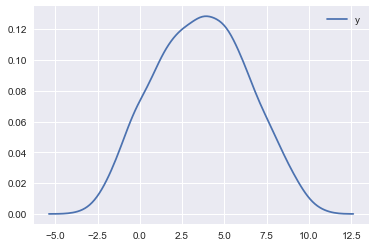

In [8]:
sns.kdeplot(ds.y)

#### To increase the statistical power of our experiment
* Increase the effect size (lol can't do much here)
* Increase the sample size (expensive?)
* Decrease the variance

## control variates
* $\tilde{y} = y - \theta x$
* the new expectation is $E[\tilde{y}] = E[y] - \theta E[x]$
* the new variance is $var(\tilde{y}) = var(y) + \alpha^2 var(x) - 2 \theta cov(y, x) $
* $\theta = \frac{cov(y, x)}{var(x)}$, this is the optimal $\theta$
* $var(\tilde{y}) = var(y) (1 - \rho^2)$
    * $\rho^2 = \frac{cov(y, x)^2}{var(y)var(x)}$
* in A/B test, we don't need to know the mean of x

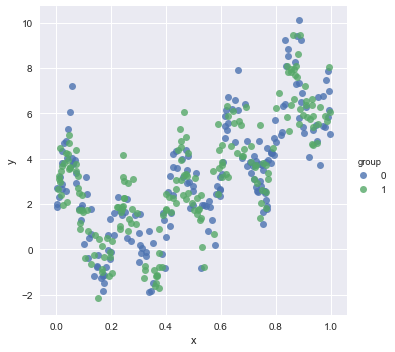

In [11]:
ds = generate_dataset(n_samples=200)
sns.lmplot(data=ds, x="x", y="y", hue="group", fit_reg=False)

In [13]:
correlation = ds.corr().loc["x","y"]
correlation

0.61126496247571149

In [14]:
def run_many_times(dataset_generator, estimator, n_runs):
    return np.array([estimator(dataset_generator()) for _ in range(n_runs)])

def compare_estimators(dataset_generator, estimators, true_uplift, n_runs=500):
    results = {}
    
    for estimator_name, estimator in estimators.items():
        res = run_many_times(dataset_generator, estimator, n_runs)
        sns.kdeplot(res, shade=True, label=estimator_name)
        
        print("Estimator: {}".format(estimator_name))
        print("\tConfidence Interval Width: {:.3f}".format(2 * np.std(res)))
        print("\tBias: {:.3f}".format(np.mean(res - true_uplift)))
        results[estimator_name] = res
        
    ymin, ymax = plt.ylim()
    plt.vlines(uplift, 0, ymax)
    plt.vlines(0, 0, ymax, linestyles="dashed")
    plt.ylim(0, ymax)
    
    return results

In [15]:
def base_estimator(ds):
    a = ds[ds.group == 0]
    b = ds[ds.group == 1]
    return b.y.mean() - a.y.mean()

Estimator: base
	Confidence Interval Width: 0.238
	Bias: -0.003


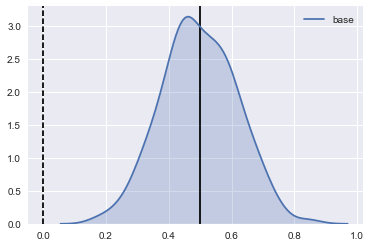

In [16]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
    },
    true_uplift=uplift
)

In [17]:
def cv_estimator(ds):
    theta = ds.cov().loc["x", "y"] / ds.cov().loc["x", "x"]
    
    ds_copy = ds.copy()
    ds_copy.y = ds.y - theta * ds.x
    
    return base_estimator(ds_copy)

Estimator: base
	Confidence Interval Width: 0.230
	Bias: -0.008
Estimator: control variate estimator
	Confidence Interval Width: 0.172
	Bias: 0.001


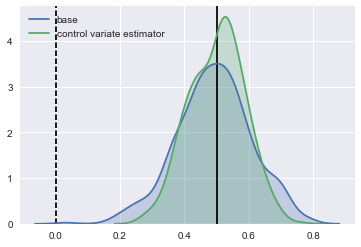

In [20]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control variate estimator": cv_estimator
    },
    true_uplift=uplift
)

### what if we used RF to get rid of variance? instead of just minusing a covariate linearly?

In [23]:
from sklearn.ensemble import RandomForestRegressor

def rf_estimator(ds):
    X = ds.x.values.reshape(-1,1)
    y = ds.y.values
    reg = RandomForestRegressor()
    reg.fit(X,y)
    
    ds_copy = ds.copy()
    ds_copy.y = ds.y - reg.predict(X)
    
    return base_estimator(ds_copy)

Estimator: base
	Confidence Interval Width: 0.240
	Bias: 0.006
Estimator: control variate estimator
	Confidence Interval Width: 0.185
	Bias: 0.007
Estimator: random forest estimator
	Confidence Interval Width: 0.044
	Bias: -0.315


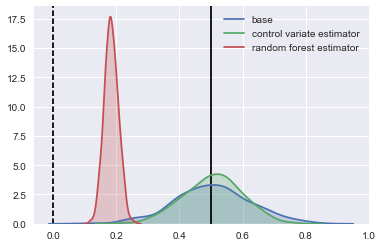

In [24]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control variate estimator": cv_estimator,
        "random forest estimator": rf_estimator
    },
    true_uplift=uplift
)

### the red stuff is messed up, because RF is overfitting
### instead we will do k-fold?

In [25]:
from sklearn.model_selection import KFold

def stacked_estimator(ds):
    kfold = KFold(n_splits=10)

    X = ds.x.values.reshape(-1,1)
    y = ds.y.values
    
    reg = RandomForestRegressor()
    
    ds_copy = ds.copy()
    ds_copy["y_pred"] = 0

    for train_index, test_index in kfold.split(X):
        
        X_train, X_test = X[train_index], X[test_index]      
        y_train, y_test = y[train_index], y[test_index]
        
        reg.fit(X_train,y_train)
        ds_copy.loc[test_index, "y_pred"] = reg.predict(X[test_index])
    
    ds_copy.y = ds_copy.y - ds_copy["y_pred"]
    
    return base_estimator(ds_copy)

Estimator: stacked random forest estimator
	Confidence Interval Width: 0.116
	Bias: -0.006
Estimator: base
	Confidence Interval Width: 0.245
	Bias: 0.003
Estimator: control variate estimator
	Confidence Interval Width: 0.174
	Bias: 0.005


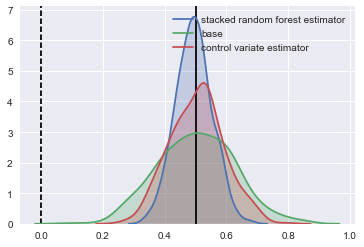

In [26]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control variate estimator": cv_estimator,
        "stacked random forest estimator": stacked_estimator
    },
    true_uplift=uplift
)

## the main idea is that if you get rid of the mean, your variance is lower!